<a href="https://colab.research.google.com/github/orifelszer/CrimeData/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*In this notebook, we implement a Decision Tree Classifier to predict crime categories based on the provided features. We will handle data preprocessing, address class imbalance using SMOTE, and evaluate the model using various metrics such as accuracy and classification reports*



In [7]:
import pandas as pd
import zipfile
import requests
from io import BytesIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import UndefinedMetricWarning



warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)



We load the training and testing datasets directly from the GitHub repository. Each dataset is stored in a compressed `.zip` format and is extracted programmatically.

In [2]:
# Base URL for your GitHub repository
base_url = "https://github.com/orifelszer/CrimeData/raw/main/"

# File names
files = {
    "X_train": "X_train_supervised.zip",
    "X_test": "X_test_supervised.zip",
    "y_train": "y_train_supervised.zip",
    "y_test": "y_test_supervised.zip"
}



In [3]:
# Function to read zip files from the repository
def load_data_from_repo(file_name):
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            extracted_file_name = z.namelist()[0]
            with z.open(extracted_file_name) as f:
                return pd.read_csv(f)
    else:
        raise Exception(f"Failed to download {file_name}")

# Load datasets
X_train = load_data_from_repo(files["X_train"])
X_test = load_data_from_repo(files["X_test"])
y_train = load_data_from_repo(files["y_train"]).values.ravel()
y_test = load_data_from_repo(files["y_test"]).values.ravel()



The target labels in the dataset are imbalanced, meaning some crime categories are significantly underrepresented. To address this issue, we use the **Synthetic Minority Oversampling Technique (SMOTE)**, which generates synthetic examples for minority classes to balance the dataset.


We implement a Decision Tree Classifier with the following parameters:
- `class_weight='balanced'`: Adjusts weights inversely proportional to class frequencies to handle imbalance.
- `random_state=42`: Ensures reproducibility of results.

Additionally, we prepare a basic model and provide a commented-out grid search implementation to explore hyperparameter optimization.

In [11]:
# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Define the Decision Tree Classifier with hyperparameter optimization
param_grid = {
    'max_depth': [15],
    'min_samples_split': [10],
    'min_samples_leaf': [5],
    'criterion': ['entropy'],
    'random_state':[42]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=1
)



In [12]:
# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Predict on the test set using the best estimator from GridSearchCV
y_pred_dt = grid_search.best_estimator_.predict(X_test)



Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [13]:
# Evaluation function
def evaluate_model(y_true, y_pred, average='weighted'):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "Recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, average=average, zero_division=0),
        "Confusion Matrix": confusion_matrix(y_true, y_pred)
    }
    return metrics



Decision Tree Accuracy: 0.03518585924379139
Decision Tree Precision: 0.32659734494817705
Decision Tree Recall: 0.03518585924379139
Decision Tree F1 Score: 0.042504175405237744
Decision Tree Confusion Matrix: [[   51     9    41     4     4    30    10     4    29    12     3    62
     66     7]
 [  317   510   459    37    38  1523   226   122   662    84    40   526
    274   648]
 [  239   126   688    32   100   294   152    82   192   152    56   412
    207    63]
 [ 2022  1011  2555   280   241  2094  1210   335  2633   498   123  2902
   2977   301]
 [11405  4811 17906  1250  2988  8171  5886  1923 12469  3662   997 19318
  17539  1299]
 [  245   517   307    18    37  2486   642    38   478   159    21   414
    326   285]
 [    7     3    15     1     1     7     2     3    10     9     1    10
     12     0]
 [ 1595   662  2328   165   244  1372   835   326  1592   563   157  2580
   2188   273]
 [   41    28    57     4    11    78    21     9    36    22     5    79
     5

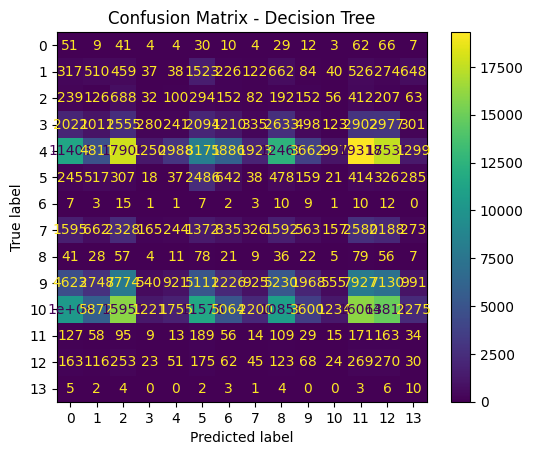

In [14]:
# Evaluate Decision Tree model
dt_metrics = evaluate_model(y_test, y_pred_dt)
for metric, value in dt_metrics.items():
    print(f"Decision Tree {metric}: {value}")

# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test, cmap='viridis')
plt.title("Confusion Matrix - Decision Tree")
plt.show()